# Classification pour Pombourg (supervisé)

Il faut au préalable extraire les /features/ pour tous les échantillons labélisés.

## Imports

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [5]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
plt.style.use("seaborn-notebook")

In [64]:
from geo3dfeatures.io import las as read_las
from geo3dfeatures.extract import compute_tree, request_tree, extract
from geo3dfeatures.features import max_normalize, sum_normalize
from geo3dfeatures.tools.kmean import load_features

## Données

In [8]:
PREFIX_NAME = "Pombourg"
SCENE_FILE = PREFIX_NAME + ".las"
EBOULIS_FILE = PREFIX_NAME + "_eboulis.las"
VEGETATION_FILE = PREFIX_NAME + "_vegetation.las"
FALAISE_FILE = PREFIX_NAME + "_falaise.las"

In [9]:
DATADIR = Path("/home/dag/data/geolithe-univers/workspace")

In [10]:
LABELS = {"eboulis": 0,
          "falaise": 1,
          "vegetation": 2}

In [11]:
# Labels des coordonnées
COORDS = list("xyz")
# Labels du channel RGB (couleurs)
COULEURS = list("rgb")

In [12]:
rawdata = read_las(DATADIR / "input" / SCENE_FILE)
rawdata = pd.DataFrame(rawdata, columns=list("xyzrgb"))

In [13]:
print("dimension: ", rawdata.shape)
rawdata.head()

dimension:  (672193, 6)


,x,y,z,r,g,b
0,1.977540e+06,5.242311e+06,902.684203,128.0,88.0,75.0
1,1.977540e+06,5.242311e+06,902.674986,117.0,78.0,66.0
2,1.977540e+06,5.242311e+06,902.731627,111.0,73.0,62.0
3,1.977538e+06,5.242330e+06,893.093306,147.0,135.0,131.0
4,1.977538e+06,5.242330e+06,893.049910,149.0,137.0,133.0


## Lecture des features pour n=50 200 1500

In [14]:
features = load_features(DATADIR, PREFIX_NAME, [50, 200, 1500])

[11:45:46] kmean.load_features (INFO) - Recover features stored in /home/dag/data/geolithe-univers/workspace/output/Pombourg/features/features.h5
[11:45:46] utils._init_num_threads (INFO) - NumExpr defaulting to 4 threads.


In [15]:
features.shape

(672193, 63)

In [16]:
features.head()

,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,planarity_1500,scattering_1500,omnivariance_1500,anisotropy_1500,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500
0,1.977525e+06,5.242324e+06,891.317748,0.334604,0.664243,2.055300,0.292404,0.085410,1.429846,0.312858,...,0.349891,0.001678,0.061972,0.998322,0.582007,1122.339474,2.042213,114.635222,917.769528,0.274770
1,1.977525e+06,5.242324e+06,891.319029,0.345110,0.653892,2.030211,0.279770,0.082896,1.483513,0.315099,...,0.360852,0.001681,0.062153,0.998319,0.588088,1113.190733,2.001808,119.309563,913.282079,0.279151
2,1.977525e+06,5.242324e+06,891.354063,0.305694,0.692340,2.015489,0.298752,0.088161,1.516258,0.308114,...,0.354059,0.001692,0.062200,0.998308,0.584418,1117.264330,1.995458,120.070114,911.133084,0.280125
3,1.977525e+06,5.242324e+06,891.390135,0.295625,0.702156,1.980571,0.312424,0.092636,1.597878,0.304651,...,0.356062,0.001723,0.062601,0.998277,0.585683,1114.302199,1.969498,123.256208,904.931612,0.285944
4,1.977525e+06,5.242324e+06,891.310728,0.335228,0.663748,2.011791,0.271698,0.080073,1.524637,0.316415,...,0.361747,0.001637,0.061615,0.998363,0.588348,1113.519679,2.010107,118.326412,918.530668,0.275069


## Features sur les échantillons

On souhaite calculer toutes les *features* sur l'ensemble des échantillons en prenant en considération la totalité de la scène.

On veut aussi calculer ces *features* pour différentes valeurs de "proches voisins".

### Études des features par label (hdf5)

On a extrait des features dans autant de voisinage et autant de classe dans des fichiers CSV. Puis rassembler l'ensemble des valeurs dans des fichiers hdf5.

On souhaite comparer des profils de certaines features en fonction de la distance (resp. du nombre de voisins) par type de classe : **falaise**, **route** et **vegetation**

In [17]:
VOISINS_NUM = [10, 20, 30, 50, 100, 200, 500, 1000, 1500, 2000]

In [25]:
KEY_H5_FORMAT = "/num_{:04d}"

def concat_columns(filepath, neighbors):
    "Pour une série de nb de voisins données, on veut concaténer toutes les colonnes"
    no_rename = ["x", "y", "z", "r", "g", "b"]
    with pd.HDFStore(filepath, mode="r") as store:
        # loop on the possible number of neighbors and concatenate features
        # we have to sort each dataframe in order to align each point x,y,z
        num_neighbor = neighbors[0]
        key = KEY_H5_FORMAT.format(num_neighbor)
        df = store[key]
        df.sort_values(by=list("xyz"), inplace=True)
        cols = [x for x in df if x not in no_rename]
        df.rename(columns={key: key + "_" + str(num_neighbor) for key in cols}, inplace=True)
        df.index = pd.Index(range(df.shape[0]))
        dataframes = [df]
        for num_neighbor in neighbors[1:]:
            key = KEY_H5_FORMAT.format(num_neighbor)
            newdf = store[key]
            newdf.drop(columns=["r", "g", "b"], inplace=True)
            newdf.sort_values(by=list("xyz"), inplace=True)
            newdf.drop(columns=["x", "y", "z"], inplace=True)
            newdf.rename(columns={key: key + "_" + str(num_neighbor) for key in cols}, inplace=True)
            newdf.index = pd.Index(range(newdf.shape[0]))
            dataframes.append(newdf)

    return pd.concat(dataframes, axis="columns")

In [19]:
KEYS = {i: "/num_{:04d}".format(i) for i in VOISINS_NUM}
KEYS

{10: '/num_0010',
 20: '/num_0020',
 30: '/num_0030',
 50: '/num_0050',
 100: '/num_0100',
 200: '/num_0200',
 500: '/num_0500',
 1000: '/num_1000',
 1500: '/num_1500',
 2000: '/num_2000'}

In [20]:
# vegetation_store = pd.HDFStore("pombourg-vegetation-features.h5", "r")
# falaise_store = pd.HDFStore("pombourg-falaise-features.h5", "r")
# eboulis_store = pd.HDFStore("pombourg-eboulis-features.h5", "r")

In [21]:
dfveg = concat_columns("pombourg-vegetation-features.h5", [50, 200, 1500])

In [22]:
dffalaise = concat_columns("pombourg-falaise-features.h5", [50, 200, 1500])

In [23]:
dfeboulis = concat_columns("pombourg-eboulis-features.h5", [50, 200, 1500])

In [24]:
LABELS

{'eboulis': 0, 'falaise': 1, 'vegetation': 2}

In [26]:
# on attribut le label à chaque échantillon
dfeboulis["label"] = 0
dffalaise["label"] = 1
dfveg["label"] = 2

In [27]:
# on met tout ça dans un seul DataFrame
datasets = pd.concat([dfeboulis, dffalaise, dfveg], axis=0)

In [28]:
datasets.shape

(73651, 73)

In [29]:
datasets.head()

,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500,bin_density_1500,bin_z_range_1500,bin_z_std_1500,label
0,1.977537e+06,5.242329e+06,893.466154,0.102856,0.888538,0.213368,0.376617,0.105810,1277.996295,0.868071,...,0.790406,933.068215,1.133958,371.814129,521.100299,0.092416,746.0,0.308615,1.521789,0
1,1.977537e+06,5.242329e+06,893.412794,0.114306,0.877906,0.221938,0.397675,0.110456,1135.577646,0.925616,...,0.783676,943.017294,1.147080,363.356412,518.349456,0.077285,746.0,0.308615,1.521789,0
2,1.977537e+06,5.242329e+06,893.350233,0.069191,0.921435,0.225106,0.400131,0.109770,1088.308161,0.973620,...,0.776052,953.072758,1.147944,362.809773,517.876294,0.062526,746.0,0.308615,1.521789,0
3,1.977537e+06,5.242329e+06,893.513106,0.086685,0.903080,0.210424,0.364487,0.106054,1332.374959,0.817127,...,0.794486,929.007483,1.142140,366.506293,531.257561,0.103562,746.0,0.308615,1.521789,0
4,1.977537e+06,5.242329e+06,893.286024,0.041353,0.950119,0.228971,0.415848,0.113795,1034.121211,0.970630,...,0.767715,963.596787,1.146678,363.611172,511.831757,0.050390,746.0,0.308615,1.521789,0


### Data shuffle & petit clean-up

In [30]:
datasets.columns

Index(['x', 'y', 'z', 'alpha_50', 'beta_50', 'radius_50', 'z_range_50',
       'std_dev_50', 'density_50', 'verticality_50', 'curvature_change_50',
       'linearity_50', 'planarity_50', 'scattering_50', 'omnivariance_50',
       'anisotropy_50', 'eigenentropy_50', 'eigenvalue_sum_50', 'radius_2D_50',
       'density_2D_50', 'eigenvalue_sum_2D_50', 'eigenvalue_ratio_2D_50',
       'bin_density_50', 'bin_z_range_50', 'bin_z_std_50', 'r', 'g', 'b',
       'alpha_200', 'beta_200', 'radius_200', 'z_range_200', 'std_dev_200',
       'density_200', 'verticality_200', 'curvature_change_200',
       'linearity_200', 'planarity_200', 'scattering_200', 'omnivariance_200',
       'anisotropy_200', 'eigenentropy_200', 'eigenvalue_sum_200',
       'radius_2D_200', 'density_2D_200', 'eigenvalue_sum_2D_200',
       'eigenvalue_ratio_2D_200', 'bin_density_200', 'bin_z_range_200',
       'bin_z_std_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'std_dev_1500', 'density_1500', 'v

In [31]:
# on shuffle un peu tout ça
datasets = datasets.sample(frac=1.)

In [32]:
datasets.head()

,x,y,z,alpha_50,beta_50,radius_50,z_range_50,std_dev_50,density_50,verticality_50,...,eigenentropy_1500,eigenvalue_sum_1500,radius_2D_1500,density_2D_1500,eigenvalue_sum_2D_1500,eigenvalue_ratio_2D_1500,bin_density_1500,bin_z_range_1500,bin_z_std_1500,label
26,1.977541e+06,5.242310e+06,906.977934,0.055589,0.943918,0.197631,0.333862,0.089334,1608.224234,0.527626,...,0.697107,811.731317,1.032571,448.415050,495.121143,0.206157,1147.0,0.626740,2.679443,1
14490,1.977561e+06,5.242287e+06,934.439032,0.264057,0.582961,0.382175,0.539627,0.163701,222.395819,0.595541,...,0.819631,3586.974887,2.172144,101.331150,3013.936403,0.422097,177.0,0.343492,1.376404,2
10355,1.977558e+06,5.242286e+06,933.964423,0.058667,0.891091,0.320800,0.486099,0.128339,376.019715,0.434515,...,0.845437,2550.948356,1.877664,135.607619,1849.379067,0.494107,780.0,1.068848,3.659027,2
21880,1.977544e+06,5.242328e+06,898.548949,0.040644,0.931116,0.179876,0.134354,0.034608,2133.003876,0.066047,...,0.860191,549.003304,0.855635,653.044590,474.831210,0.737394,1057.0,0.209751,0.835526,0
29740,1.977548e+06,5.242311e+06,912.366087,0.078451,0.920908,0.184410,0.326294,0.087877,1979.541286,0.569688,...,0.696517,830.069680,1.053649,430.653296,481.286475,0.192294,1331.0,0.686180,3.137115,1


On va retirer quelques colonnes (des /features/ qui nous semblent trop redondantes ou corrélées). Il vaut mieux éviter la multicolinéarité.

In [33]:
# celles qui sont corrélées à certaines, les z- accumulation features, etc.
def complete_with_voisin(name, neighbors):
    "on complète juste le nom de la features avec le suffix '_{num_voisin}'"
    return [name + "_{}".format(x) for x in neighbors]

drop_cols = ["bin_z_range", "bin_z_std", "bin_density", "planarity", "eigenvalue_ratio_2D",
             "eigenvalue_sum_2D", "eigenvalue_sum", "radius_2D", "std_dev", "density_2D",
             "scattering", "omnivariance", "curvature_change"]
full_cols_to_drop = sum((complete_with_voisin(x, [50, 200, 1500]) for x in drop_cols), [])
full_cols_to_drop

['bin_z_range_50',
 'bin_z_range_200',
 'bin_z_range_1500',
 'bin_z_std_50',
 'bin_z_std_200',
 'bin_z_std_1500',
 'bin_density_50',
 'bin_density_200',
 'bin_density_1500',
 'planarity_50',
 'planarity_200',
 'planarity_1500',
 'eigenvalue_ratio_2D_50',
 'eigenvalue_ratio_2D_200',
 'eigenvalue_ratio_2D_1500',
 'eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500',
 'eigenvalue_sum_50',
 'eigenvalue_sum_200',
 'eigenvalue_sum_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'std_dev_50',
 'std_dev_200',
 'std_dev_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'scattering_50',
 'scattering_200',
 'scattering_1500',
 'omnivariance_50',
 'omnivariance_200',
 'omnivariance_1500',
 'curvature_change_50',
 'curvature_change_200',
 'curvature_change_1500']

In [34]:
clean_dataset = (datasets.drop(columns=full_cols_to_drop)
                 .drop(columns=["x", "y", "z"]))

In [35]:
print(clean_dataset.shape)
clean_dataset.head()

(73651, 31)


,alpha_50,beta_50,radius_50,z_range_50,density_50,verticality_50,linearity_50,anisotropy_50,eigenentropy_50,r,...,alpha_1500,beta_1500,radius_1500,z_range_1500,density_1500,verticality_1500,linearity_1500,anisotropy_1500,eigenentropy_1500,label
26,0.055589,0.943918,0.197631,0.333862,1608.224234,0.527626,0.105340,0.999689,0.693083,138.0,...,0.013373,0.985086,1.035869,1.827591,322.601531,0.541394,0.026406,0.998985,0.697107,1
14490,0.264057,0.582961,0.382175,0.539627,222.395819,0.595541,0.435355,0.915925,0.822007,168.0,...,0.309395,0.520960,2.181910,2.752838,34.519989,0.166851,0.493908,0.909729,0.819631,2
10355,0.058667,0.891091,0.320800,0.486099,376.019715,0.434515,0.112614,0.967853,0.764882,101.0,...,0.037227,0.826901,1.880699,3.499130,53.904330,0.322411,0.075059,0.908682,0.845437,2
21880,0.040644,0.931116,0.179876,0.134354,2133.003876,0.066047,0.078825,0.981743,0.739077,171.0,...,0.089524,0.750427,0.858390,0.931305,566.927551,0.105756,0.172797,0.897025,0.860191,0
29740,0.078451,0.920908,0.184410,0.326294,1979.541286,0.569688,0.145516,0.999603,0.691940,151.0,...,0.026951,0.971644,1.062733,1.897278,298.750669,0.574021,0.052511,0.999088,0.696517,1


In [36]:
clean_dataset.columns

Index(['alpha_50', 'beta_50', 'radius_50', 'z_range_50', 'density_50',
       'verticality_50', 'linearity_50', 'anisotropy_50', 'eigenentropy_50',
       'r', 'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'density_200', 'verticality_200', 'linearity_200', 'anisotropy_200',
       'eigenentropy_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'density_1500', 'verticality_1500', 'linearity_1500',
       'anisotropy_1500', 'eigenentropy_1500', 'label'],
      dtype='object')

### Entrainement / Regression Logistique

In [38]:
# notre modèle
lr = LogisticRegression(random_state=42, solver="lbfgs", multi_class="multinomial", max_iter=200)

In [39]:
#  notre classifier qui est une composition d'une normalisation + logistic regression
clf = make_pipeline(preprocessing.MinMaxScaler(), lr)

In [40]:
# Cross-validation. ici cv=5, i.e. qu'on va entrainer/tester 5 fois de suite avec des jeux train/test différents (et stratifiés)
scores = cross_val_score(clf, clean_dataset.drop(columns="label"), clean_dataset["label"], cv=5)

[11:51:17] warnings._showwarnmsg (WARNING) - /home/dag/.local/share/virtualenvs/geo3d/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

[11:51:24] warnings._showwarnmsg (WARNING) - /home/dag/.local/share/virtualenvs/geo3d/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

[11:51:33] warnings._showwarnmsg (WARNING) - /home/dag/.local/share/virtualenvs/geo3d/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

[11:51:41] warnings._showwarnmsg (WARNING) - /home/dag/.local/share/virtualenvs/geo3d/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

In [43]:
# scores de précision pour chaque cross-validation
scores
# très proche de 1!!! Overfitting ??

array([0.99823501, 0.99884589, 0.99816701, 0.99891378, 0.99911745])

In [44]:
# on entraine la totalité du classifier sur tout le jeu.
clf.fit(clean_dataset.drop(columns="label"), clean_dataset["label"])

[11:52:43] warnings._showwarnmsg (WARNING) - /home/dag/.local/share/virtualenvs/geo3d/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [47]:
# exemple de prédiction des labels pour 5 points de la scène
clf.predict(clean_dataset.drop(columns="label").iloc[:5])

array([1, 2, 2, 0, 1])

In [48]:
# exemple de prédiction de **proba** pour 5 points de la scène
clf.predict_proba(clean_dataset.drop(columns="label").iloc[:5])

array([[2.15912377e-03, 9.97811748e-01, 2.91279335e-05],
       [4.64874332e-03, 3.26550420e-16, 9.95351257e-01],
       [3.52132892e-05, 4.16764003e-05, 9.99923110e-01],
       [9.99999367e-01, 1.87517032e-12, 6.32711369e-07],
       [4.74440072e-03, 9.95244001e-01, 1.15985651e-05]])

### Sérialisation du modèle d'apprentissage

In [34]:
import pickle
# from joblib import dump

In [35]:
with open("model-pombourg.pkl", "wb") as fobj:
    pickle.dump(clf, fobj)

### Prédiction sur l'ensemble de la scène

On essaie avec l'ensemble de la scène. Il faut avoir les mêmes colonnes et dans le même sens et normaliser tout pareil.

In [49]:
drop_cols = ["planarity", "eigenvalue_ratio_2D",
            "eigenvalue_sum_2D", "eigenvalue_sum", "radius_2D", "std_dev", "density_2D",
             "scattering", "omnivariance", "curvature_change"]
dataset_cols_to_drop = sum((complete_with_voisin(x, [50, 200, 1500]) for x in drop_cols), [])
dataset_cols_to_drop

['planarity_50',
 'planarity_200',
 'planarity_1500',
 'eigenvalue_ratio_2D_50',
 'eigenvalue_ratio_2D_200',
 'eigenvalue_ratio_2D_1500',
 'eigenvalue_sum_2D_50',
 'eigenvalue_sum_2D_200',
 'eigenvalue_sum_2D_1500',
 'eigenvalue_sum_50',
 'eigenvalue_sum_200',
 'eigenvalue_sum_1500',
 'radius_2D_50',
 'radius_2D_200',
 'radius_2D_1500',
 'std_dev_50',
 'std_dev_200',
 'std_dev_1500',
 'density_2D_50',
 'density_2D_200',
 'density_2D_1500',
 'scattering_50',
 'scattering_200',
 'scattering_1500',
 'omnivariance_50',
 'omnivariance_200',
 'omnivariance_1500',
 'curvature_change_50',
 'curvature_change_200',
 'curvature_change_1500']

In [50]:
cdf = features.drop(columns=dataset_cols_to_drop).drop(columns=["x", "y", "z"])

In [51]:
cdf.shape

(672193, 30)

In [52]:
cdf.columns

Index(['alpha_50', 'beta_50', 'radius_50', 'z_range_50', 'density_50',
       'verticality_50', 'linearity_50', 'anisotropy_50', 'eigenentropy_50',
       'r', 'g', 'b', 'alpha_200', 'beta_200', 'radius_200', 'z_range_200',
       'density_200', 'verticality_200', 'linearity_200', 'anisotropy_200',
       'eigenentropy_200', 'alpha_1500', 'beta_1500', 'radius_1500',
       'z_range_1500', 'density_1500', 'verticality_1500', 'linearity_1500',
       'anisotropy_1500', 'eigenentropy_1500'],
      dtype='object')

In [53]:
set(cdf.columns) == set(clean_dataset.drop(columns="label").columns)

True

In [54]:
# normalement, on n'a pas besoin de normaliser chaque features puisque mon classifier est
# un pipeline (minmax + log reg)
# for name in cdf:
#    cdf[name] = max_normalize(cdf[name])

In [55]:
clf.predict(cdf.values[:10, :])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [56]:
features["label"] = clf.predict(cdf.values)

In [57]:
features.shape

(672193, 64)

In [59]:
# Répartition des labels dans la scène total
features.groupby("label")["label"].count()

label
0    331598
1    219066
2    121529
Name: label, dtype: int64

In [65]:
def colorize_clusters(points, labels, colors):
    """Associated a (r, g, b) color for each record of a dataframe, depending
    on the cluster id

    Parameters
    ----------
    points : pandas.DataFrame
        Set of (x, y, z) points
    labels : np.array or pd.Series
    colors : dict
        Each label, one color

    Returns
    -------
    pandas.DataFrame
        Colorized points, i.e. set of (x, y, z, r, g, b) clustered points
    """
    colors = np.array([colors[l] for l in labels]) * 256
    colors = pd.DataFrame(colors, columns=["r", "g", "b"], dtype=np.uint8)
    return points.join(colors)

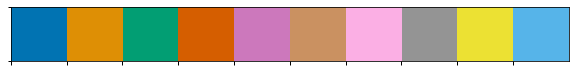

In [61]:
sns.palplot(sns.color_palette("colorblind"))

In [63]:
print(LABELS)
palette = sns.color_palette("colorblind")
colors = {0: palette[7],  # éboulis / gris
          1: palette[0],  # falaise / bleu
          2: palette[2]}  # végétation / vert
colors

{'eboulis': 0, 'falaise': 1, 'vegetation': 2}


{0: (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 1: (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 2: (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

In [67]:
outdf = colorize_clusters(features[COORDS], features["label"], colors)

In [68]:
def savelas(input_file, data, output_file):
    import laspy
    with laspy.file.File(input_file, mode="r") as input_las:
        outfile = laspy.file.File(
            output_file, mode="w", header=input_las.header
        )
        outfile.x = data.x
        outfile.y = data.y
        outfile.z = data.z
        outfile.red = data.r
        outfile.green = data.g
        outfile.blue = data.b
        outfile.close()

On enregistre la scène avec la couleur pour chaque label dans un .las

In [69]:
savelas(DATADIR / "input" / SCENE_FILE, outdf, "pombourg-segmentation.las")